<a href="https://colab.research.google.com/github/chinmay250/Malaria-Detection/blob/main/malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
# ## Mount google drive
# from google.colab import drive
# drive.mount("/content/drive")

In [2]:
## Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import tensorflow.keras
import tensorflow_datasets as tfds
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy,RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization

# **Data Preparation**

### **Dataset Loading**

In [3]:
## Load the malaria images dataset from tensorflow

dataset, dataset_info = tfds.load("malaria",
                                  with_info=True,
                                  as_supervised=True,
                                  shuffle_files=True,
                                  split =["train"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteHSYQ99/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
## checking the dataset and dataset_info

print(dataset)
print(dataset_info)

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmp4wicdsuhtfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      tit

In [5]:
## Function for splitting the dataset into train,validation,test

def splits(dataset,train_ratio: float,val_ratio:float,test_ratio:float):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

    return train_dataset,val_dataset,test_dataset


In [6]:
## Applying the splits function
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train,val,test = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)


In [7]:
## Printing the first data points

print(list(train.take(1).as_numpy_iterator()))
print(list(val.take(1).as_numpy_iterator()))
print(list(test.take(1).as_numpy_iterator()))


[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

### **Data Visualization**

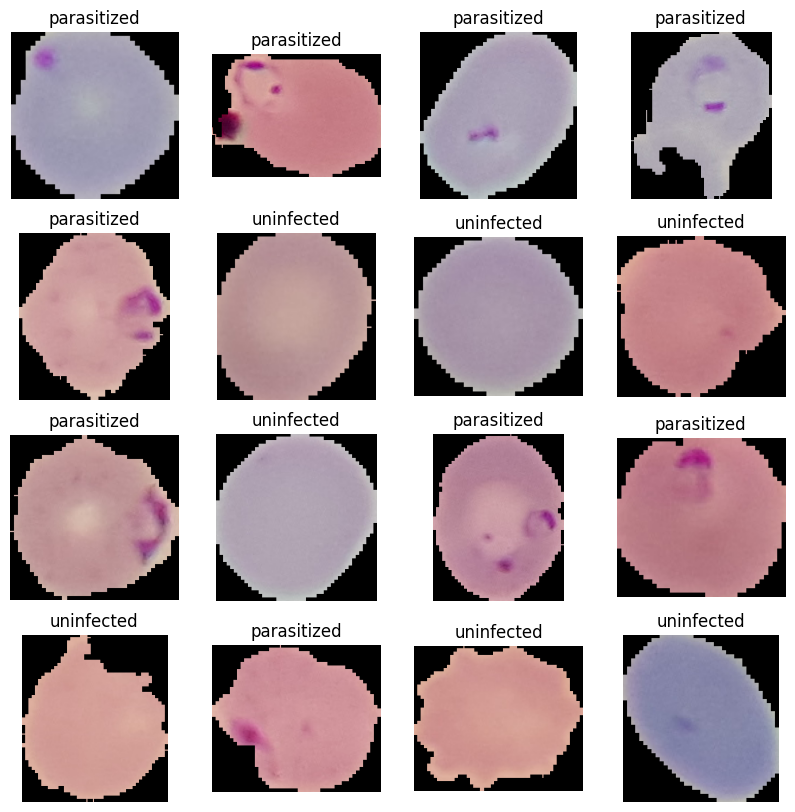

In [8]:
plt.figure(figsize=[10,10])
for i,(image,label) in enumerate(train.take(16)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

### **Data Preprocessing**

In [9]:
## Resizing the image to 224 x 224 and rescaling

IM_SIZE = 224
def resize_rescale(image,label):
    return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label


In [10]:
train = train.map(resize_rescale)
val = val.map(resize_rescale)
test = test.map(resize_rescale)

In [11]:
BATCH_SIZE = 32
train_dataset = train.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# **Model Creation**

In [12]:
lenet_model = tf.keras.Sequential([

    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6 ,kernel_size= 3, strides=1, padding = 'valid',activation = "relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16 ,kernel_size= 3, strides=1,padding = 'valid',activation = "relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100,activation="relu"),
    BatchNormalization(),

    Dense(10,activation="relu"),
    BatchNormalization(),

    Dense(1,activation="sigmoid"),

])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [13]:
lenet_model.compile(optimizer = Adam(learning_rate=0.01),
                    loss = BinaryCrossentropy(from_logits=False),
                    metrics = 'accuracy')

In [14]:
history = lenet_model.fit(train_dataset,validation_data=val_dataset, epochs=20,verbose=1)

Epoch 1/20
689/689 [==============================] - 68s 82ms/step - loss: 0.4263 - accuracy: 0.7999 - val_loss: 0.2313 - val_accuracy: 0.9201
Epoch 2/20
689/689 [==============================] - 41s 59ms/step - loss: 0.2119 - accuracy: 0.9266 - val_loss: 0.6656 - val_accuracy: 0.8722
Epoch 3/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1932 - accuracy: 0.9358 - val_loss: 0.2290 - val_accuracy: 0.9434
Epoch 4/20
689/689 [==============================] - 43s 62ms/step - loss: 0.1754 - accuracy: 0.9427 - val_loss: 0.1733 - val_accuracy: 0.9485
Epoch 5/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1608 - accuracy: 0.9473 - val_loss: 0.1558 - val_accuracy: 0.9485
Epoch 6/20
689/689 [==============================] - 43s 63ms/step - loss: 0.1492 - accuracy: 0.9518 - val_loss: 0.1739 - val_accuracy: 0.9514
Epoch 7/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1497 - accuracy: 0.9500 - val_loss: 0.2190 - val_accuracy:

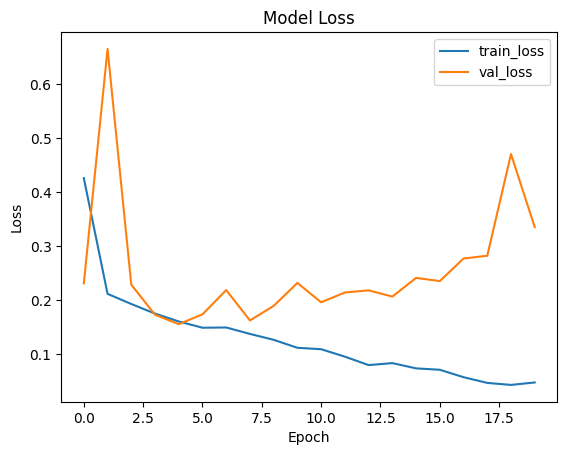

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train_loss','val_loss'])
plt.show()

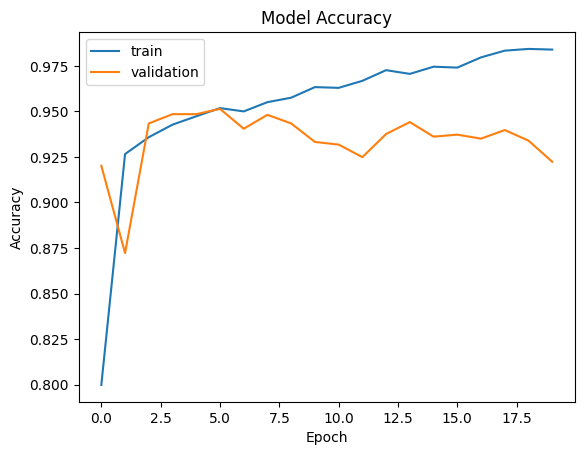

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train','validation'])
plt.show()

# **Model Evaluation**

In [22]:
test

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [23]:
## Batching to make correct shape
test = test.batch(1)
test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [24]:
## Evaluate the test dataset
lenet_model.evaluate(test)

2757/2757 [==============================] - 22s 4ms/step - loss: 0.4218 - accuracy: 0.9122


[0.42177754640579224, 0.9122234582901001]

In [28]:
## predicting

def parasite_or_not(x):
    if x<0.5:
        return str("Parasitized")
    else:
        return str("Uninfected")

parasite_or_not(lenet_model.predict(test.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'Parasitized'

1/1 [==============================] - 0s 30ms/step


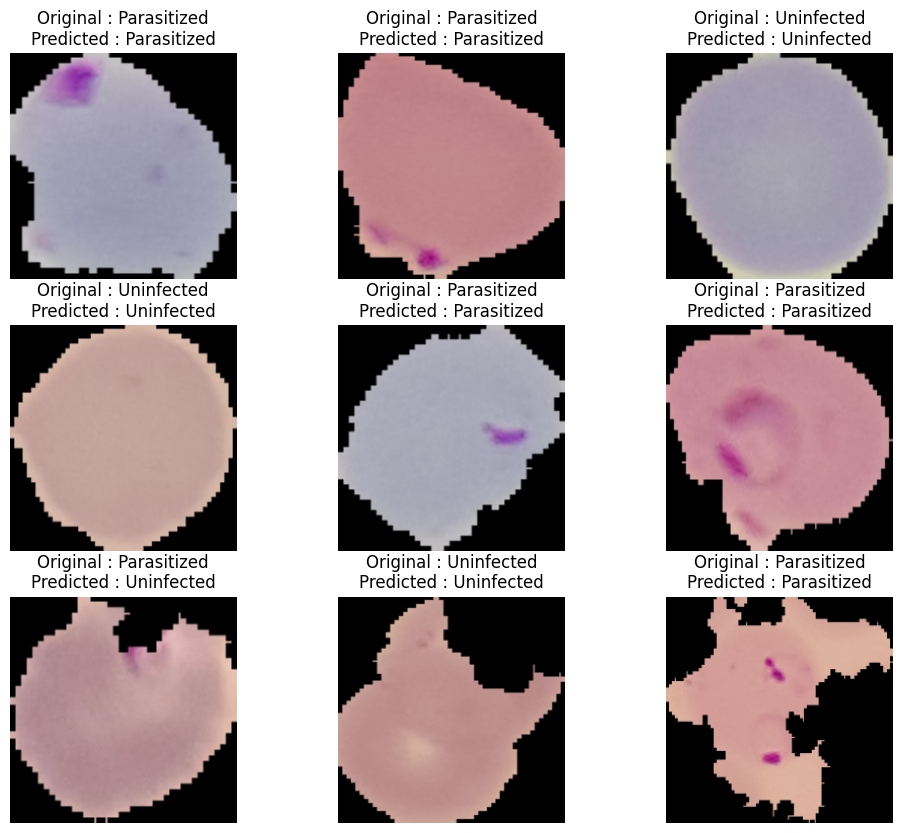

In [34]:
## Predicting and Plotting 9 test Images
plt.figure(figsize=[12,10])
for i,(image,label) in enumerate(test.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0])
    plt.title(str("Original : "+parasite_or_not(label.numpy()[0]))+"\nPredicted : "+ str(parasite_or_not(lenet_model.predict(image)[0][0])))
    plt.axis("off")

